<a href="https://colab.research.google.com/github/LakshmiHegde/project/blob/master/summarize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [0]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# **Importing Libraries**

In [6]:
import numpy as np
import pandas as pd 
import re
import nltk
nltk.download('stopwords')
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


# **Reading Dataset**

In [0]:
data=pd.read_csv(root_dir+"Dataset/Reviews.csv",nrows=100000)

# **Drop duplicates and NA values**

In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88421 non-null int64
ProductId                 88421 non-null object
UserId                    88421 non-null object
ProfileName               88421 non-null object
HelpfulnessNumerator      88421 non-null int64
HelpfulnessDenominator    88421 non-null int64
Score                     88421 non-null int64
Time                      88421 non-null int64
Summary                   88421 non-null object
Text                      88421 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


Here is the dictionary that we will use for expanding the contractions:

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [0]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [13]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [0]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [15]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary


# **Drop empty rows**

In [0]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

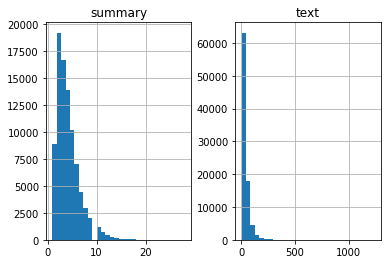

In [18]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [19]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


In [0]:
max_text_len=30
max_summary_len=8


In [0]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [0]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)


# **Tokenizer**

Text Tokenizer

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# **Rarewords and its coverage**

In [25]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [27]:
x_voc

8440

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [29]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [31]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(42453, 42453)

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [34]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
_________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [37]:

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 41346 samples, validate on 4588 samples
Epoch 1/50
41346/41346 [==============================] - 69s 2ms/sample - loss: 2.8235 - val_loss: 2.6290
Epoch 2/50
41346/41346 [==============================] - 58s 1ms/sample - loss: 2.5139 - val_loss: 2.4517
Epoch 3/50
41346/41346 [==============================] - 55s 1ms/sample - loss: 2.3634 - val_loss: 2.3227
Epoch 4/50
41346/41346 [==============================] - 57s 1ms/sample - loss: 2.2662 - val_loss: 2.2565
Epoch 5/50
41346/41346 [==============================] - 55s 1ms/sample - loss: 2.1951 - val_loss: 2.2114
Epoch 6/50
41346/41346 [==============================] - 55s 1ms/sample - loss: 2.1416 - val_loss: 2.1765
Epoch 7/50
41346/41346 [==============================] - 55s 1ms/sample - loss: 2.0995 - val_loss: 2.1648
Epoch 8/50
41346/41346 [==============================] - 55s 1ms/sample - loss: 2.0603 - val_loss: 2.1162
E

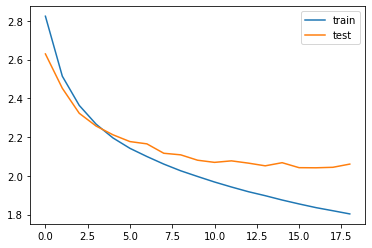

In [38]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# **Inference**

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [43]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: gave caffeine shakes heart anxiety attack plus tastes unbelievably bad stick coffee tea soda thanks 
Original summary: hour 
Predicted summary:  not so good


Review: got great course good belgian chocolates better 
Original summary: would like to give it stars but 
Predicted summary:  great


Review: one best flavored coffees tried usually like flavored coffees one great serve company love 
Original summary: delicious 
Predicted summary:  great coffee


Review: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging 
Predicted summary:  great salt


Review: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summary: turkey jerky is great 
Predicted summary:  good stuff


Review: best salad dressing delivered promptly quantities last vidalia onion dressing compares made oak hill farms sometimes find costco order front door want even order

In [0]:
doc=root_dir+"documents"
os.chdir(doc)

In [45]:
os.getcwd()

'/content/gdrive/My Drive/documents'

## **INFERENCE**

In [46]:
!pip install PyPDF2
!pip install docx2txt
!pip install sys


     |████████████████████████████████| 81kB 5.5MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=87384cf7291baa5bbf3c9d0101900a53c6f9a1d6457e842e5112ffcd9787a5f9
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2
  Created wheel for docx2txt: filename=docx2txt-0.8-cp36-none-any.whl size=3963 sha256=fe9a1090b61d45f7100389a0055ffda3f8c3bf8f5c289f8f4ebd4dd7ea5a3a90
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
Successfully built docx2txt
ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


Importing libraries

In [0]:
# numpy library helps in working with arrays: array creation and manipulation
# this implementation uses array for storing the matrices generated as 2-D arrays
# PyPDF2 is a library used for reading the PDF files
# docx2txt is the library used for reading Word documents 
# sys library has been used for printing the size of data structures used in the program


### 1. Importing important libraries

import numpy as np
import PyPDF2
import docx2txt
import sys


In [0]:
# matplotlib is a library that is used to visualize the data by drawing graphs of matrix inputs
# we will use it for drawing the matrices generated later in the program 
# %matplotlib inline is a command used to show the graphs in the jupyter notebook

import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
# networkx library helps in working with graphs ...
# and later performing the PageRank algorithm ...
# which is the crux of this implementation to find ...
# the importance of each sentence using their 'rank' as a metric ...
# rank, the output of the method textrank, is a measure of importance of sentences
# this library has been used in the cell no. ()

import networkx as nx


In [0]:
# the PunktSentenceTokenizer library is being imported from the file punkt.py contained in package nltk.tokenize 
# this is used to tokenize the document into sentences

# Tokenization: Tokenization is the process of demarcating and possibly classifying.. 
# sections of a string of input characters. 
# The resulting tokens are then passed on to some other form of processing. 

from nltk.tokenize.punkt import PunktSentenceTokenizer


In [0]:
# TfidfTransformer and CountVectorizer libraries are being imported

# CountVectorizer: In this implementation, a CountVectorizer object is being created that ..
# will be used for creating the document-term matrix

# tFidTransformer: In this implementation,TfidfTransformer is used for executing the method fit_transform()... 
# which provides the output as a document-term matrix normalized (value 0-1) according to the TF-IDF
# TF(Term Frequency): the no. of times a term(a word here) appears in the current document(single sentence here)
# IDF(Inverse Document Frequency): the no. of times a term(a word here) appears in the entire corpus
# Corpus: set of all sentences


from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer



# **2. Function to read the document from user**

Supported formats: .txt, .pdf 

Input: Takes the name of the file as input. 

Output: Returns a string output containing the contents of the file.


In [0]:
# we are going to show an example of how the method is working
# first let's take the document as an input
def readDoc():
    name = input('Please input a file name: ') 
    print('You have asked for the document {}'.format(name))

    # now read the type of document
    if name.lower().endswith('.txt'):
        choice = 1
    elif name.lower().endswith('.pdf'):
        choice = 2
    else:
        choice = 3
        # print(name)
    #print(choice)
    # Case 1: if it is a .txt file
        
    if choice == 1:
        f = open(name, 'r')
        document = f.read()
        f.close()
            
    # Case 2: if it is a .pdf file
    elif choice == 2:
        pdfFileObj = open(name, 'rb')
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        pageObj = pdfReader.getPage(0)
        document = pageObj.extractText()
        pdfFileObj.close()
    
    # Case 3: none of the format
    else:
        print('Failed to load a valid file')
        print('Returning an empty string')
        document = ''
    
    #print(type(document))
    return document


# **3. Function to tokenize the document**

Input: String of text document

Output: A list containing sentences as its elements



In [0]:
# the function used for tokenizing the sentences
# tokenization of a sentence: '''provided in cell() above'''

def tokenize(document):
    # We are tokenizing using the PunktSentenceTokenizer
    # we call an instance of this class as sentence_tokenizer
    doc_tokenizer = PunktSentenceTokenizer()
    
    # tokenize() method: takes our document as input and returns a list of all the sentences in the document
    
    # sentences is a list containing each sentence of the document as an element
    sentences_list = doc_tokenizer.tokenize(document)
    return sentences_list


# **4. Read the document**




Please input a file name: Story.txt
You have asked for the document Story.txt
The length of the file is: 950

The size of the list in Bytes is: 208

The size of the item 0 in Bytes is: 156

The size of the list "sentences" is: 11
Param (Puneeth Rajakumar) son of a heart specialist doctor Jayanth is an eager to know many things in life.
He keeps on shuffling from one place to another.
A gold medalist in Bachelor of Science takes six attempts to complete his master's degree because of his friends.
He is a rich guy and he can do any task easily.
He falls in love with Deepa (Deepa Sannidhi), but Sanvi (Aindrita Ray) is in love with him.
He does not have any intentions other than friend with Sanvi.
So he makes it clear and shows interest in getting Deepa as his partner in life.
There are tough guys in the house of Deepa that he has to convince.
But the proposal comes in a fit of anger of Deepa for the marriage.
After marriage Deepa delivering a child a few years' later dies and Sanvi thi

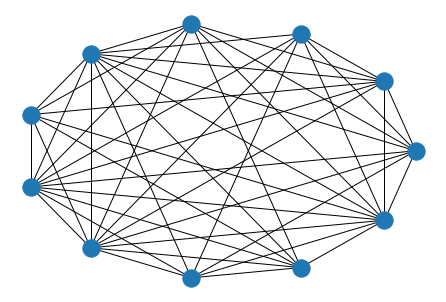


Ranks

0 0.08426383029879052
1 0.0768942613883989
2 0.08319644471132498
3 0.08578348718111396
4 0.10427453769815964
5 0.08410930424517382
6 0.09310946355238117
7 0.0983513663899693
8 0.09898350288411946
9 0.08227758073527573
10 0.10875622091529279


0.10875622091529279
0.0768942613883989
Param reacts to it in a very jovial style and he is under the impression Deepa is not physically with him but mentally she has not left him. He falls in love with Deepa (Deepa Sannidhi), but Sanvi (Aindrita Ray) is in love with him. But the proposal comes in a fit of anger of Deepa for the marriage. There are tough guys in the house of Deepa that he has to convince.


Summary written to result.txt file successfully






In [0]:
# reading a file and 
# printing the size of the file
while True:
  print("\n\n")
  document = readDoc()
  print('The length of the file is:', end=' ')
  print(len(document))
  sentences_list = tokenize(document)
  print('\nThe size of the list in Bytes is: {}'.format(sys.getsizeof(sentences_list)))
  print('\nThe size of the item 0 in Bytes is: {}'.format(sys.getsizeof(sentences_list[0])))
  #print(type(sentences_list))
  print('\nThe size of the list "sentences" is: {}'.format(len(sentences_list)))
  for i in sentences_list:
    print(i)
  cv = CountVectorizer()
  cv_matrix = cv.fit_transform(sentences_list)
  #cv_demo = CountVectorizer() # a demo object of class CountVectorizer
  #text_demo = ["Ashish is good, you are bad", "I am not bad"] 
  #res_demo = cv_demo.fit_transform(text_demo)
  #print('Result demo array is {}'.format(res_demo.toarray()))
  #print('Feature list: {}'.format(cv_demo.get_feature_names()))
  print('The data type of bow matrix {}'.format(type(cv_matrix)))
  print('Shape of the matrix {}'.format(cv_matrix.get_shape))
  print('Size of the matrix is: {}'.format(sys.getsizeof(cv_matrix)))
  print(cv.get_feature_names())
  print(cv_matrix.toarray())
  normal_matrix = TfidfTransformer().fit_transform(cv_matrix)
  print(normal_matrix.toarray())
  print(normal_matrix.T.toarray)
  res_graph = normal_matrix * normal_matrix.T
  nx_graph = nx.from_scipy_sparse_matrix(res_graph)
  print('\n\nResult Graph\n\n')
  nx.draw_circular(nx_graph)
  print('\nNumber of edges {}'.format(nx_graph.number_of_edges()))
  print('\nNumber of vertices {}'.format(nx_graph.number_of_nodes()))
  plt.show()
  #print('The memory used by the graph in Bytes is: {}'.format(sys.getsizeof(nx_graph)))
  ranks = nx.pagerank(nx_graph)
  #print(type(ranks))
  #print('The size used by the dictionary in Bytes is: {}'.format(sys.getsizeof(ranks)))

  print('\nRanks\n') 
  for i in ranks:
    print(i, ranks[i])
  print('\n')
  sentence_array = sorted(((ranks[i], s) for i, s in enumerate(sentences_list)), reverse=True)
  sentence_array = np.asarray(sentence_array)
  rank_max = float(sentence_array[0][0])
  rank_min = float(sentence_array[len(sentence_array) - 1][0])

  print(rank_max)
  print(rank_min)
  temp_array = []
  flag = 0
  if rank_max - rank_min == 0:
    temp_array.append(0)
    flag = 1
  if flag != 1:
    for i in range(0, len(sentence_array)):
        temp_array.append((float(sentence_array[i][0]) - rank_min) / (rank_max - rank_min))

  #print(len(temp_array))
  threshold = (sum(temp_array) / len(temp_array)) + 0.2
  sentence_list = []
  if len(temp_array) > 1:
    for i in range(0, len(temp_array)):
        if temp_array[i] > threshold:
                sentence_list.append(sentence_array[i][1])
  else:
    sentence_list.append(sentence_array[0][1])
  model = sentence_list
  summary = " ".join(str(x) for x in sentence_list)
  print(summary)


  f = open('result.txt', 'w')
  f.write(summary)
  print('\n\nSummary written to result.txt file successfully\n')
  f.flush()


  #for lines in sentence_list:
   # print(lines)



# **5. Generate a list of sentences in the document**

In [0]:
name = input()
if name=='q' or name=='Q':
  sys.exit(0)